In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
# Importing required libraries

import transformers
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, get_linear_schedule_with_warmup
from transformers import DistilBertModel
from torch.optim import AdamW
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Reading the data that has been scraped
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis with BERT/data/reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appID
0,785f70a4-49a8-4aa1-8885-dc4d4ff8dd0e,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app is good but one problem most of the ti...,4,10,18.5.0.300,2019-03-15 16:47:41,NaN,NaN,18.5.0.300,most relevant,in.amazon.mShop.android.shopping
1,a523546a-547d-4b6f-981d-36f09750987e,Manisha Nigam,https://play-lh.googleusercontent.com/a/ACg8oc...,This app is quite nice the products are also a...,4,0,NaN,2021-02-01 07:27:59,"Dear Manisha Nigam,\nWe're glad you liked our ...",2021-02-01 09:18:21,NaN,most relevant,com.manash.purplle
2,517912a9-84bd-4af7-838d-5611eaba811f,Subrata Biswas,https://play-lh.googleusercontent.com/a-/ALV-U...,Always maintain your's Goodwill. These apps ha...,4,0,7.47,2022-07-05 08:20:27,"Hi Flipkart User, Thank you so much for your f...",2022-07-06 11:55:27,7.47,most relevant,com.flipkart.android
3,51bc9a60-2bba-4355-8c32-40bf1d4d2d7d,Bhavishtha Patel,https://play-lh.googleusercontent.com/a-/ALV-U...,"""I've been using the Domino's app for a while ...",5,604,12.0.04,2025-02-15 19:55:41,"Hi, you really know how to make our day! We ar...",2025-02-15 21:40:12,12.0.04,most relevant,com.Dominos
4,341e97d3-c1a5-4c99-89a3-8cc5ac14775b,anuradha agarwal,https://play-lh.googleusercontent.com/a/ACg8oc...,First you give cashback then you show it can't...,1,0,4.75.2,2025-03-16 18:31:41,This was not intended. We request you to share...,2025-03-16 18:32:32,4.75.2,most relevant,in.swiggy.android


In [ ]:
df.shape

(26764, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26764 entries, 0 to 26763
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              26764 non-null  object
 1   userName              26764 non-null  object
 2   userImage             26764 non-null  object
 3   content               26764 non-null  object
 4   score                 26764 non-null  int64 
 5   thumbsUpCount         26764 non-null  int64 
 6   reviewCreatedVersion  23488 non-null  object
 7   at                    26764 non-null  object
 8   replyContent          18780 non-null  object
 9   repliedAt             18780 non-null  object
 10  appVersion            23488 non-null  object
 11  sortOrder             26764 non-null  object
 12  appID                 26764 non-null  object
dtypes: int64(2), object(11)
memory usage: 2.7+ MB


In [ ]:
df.score

,score
0,4
1,4
2,4
3,5
4,1
...,...
26759,5
26760,1
26761,1
26762,4


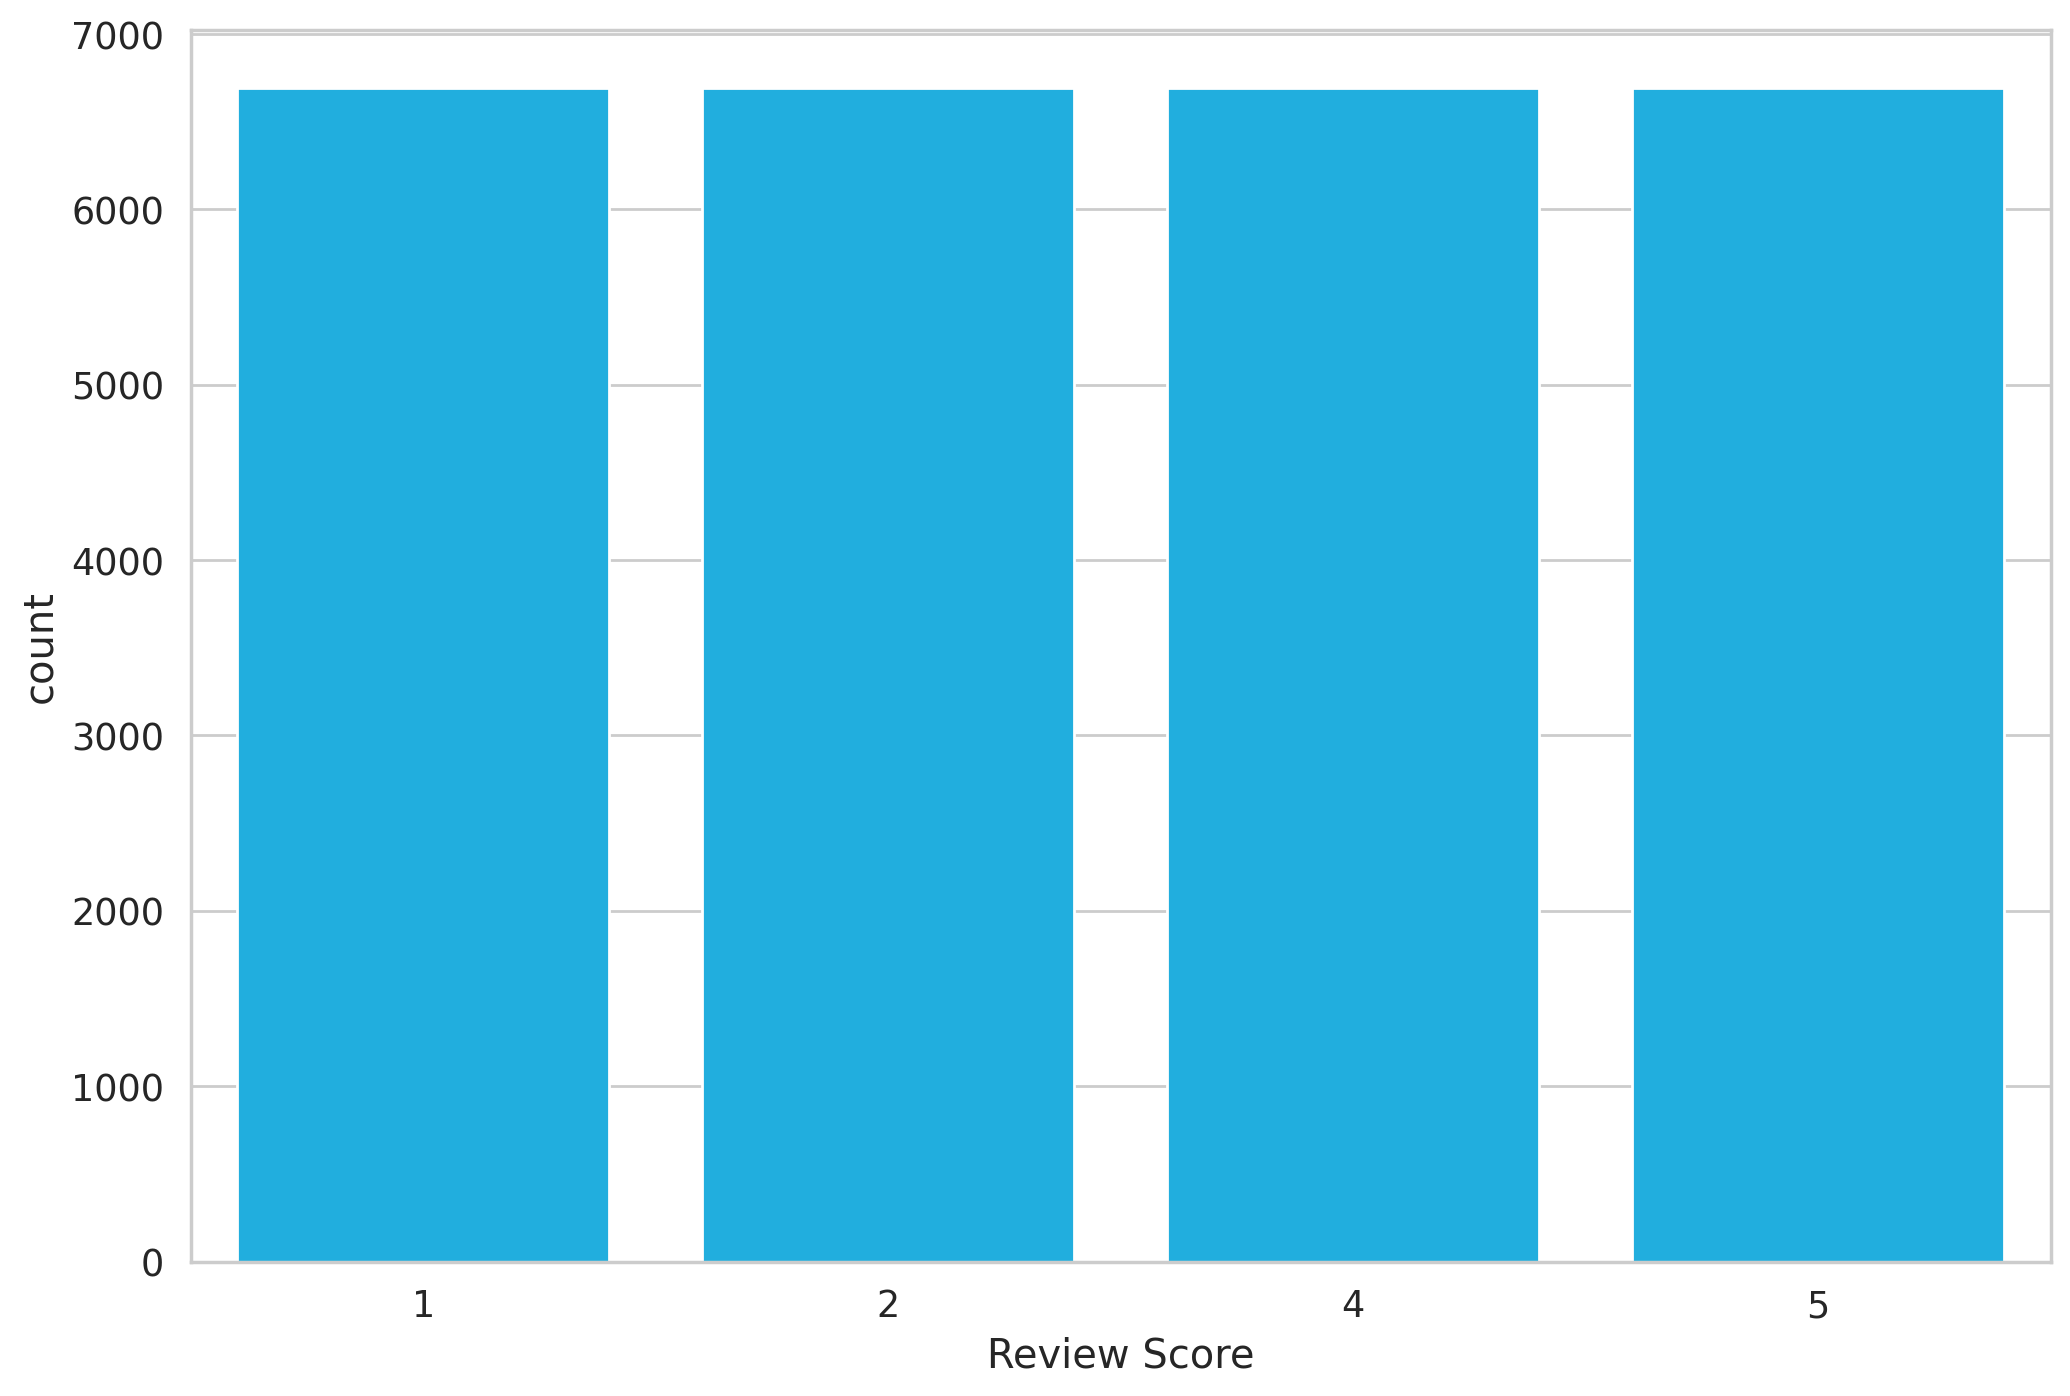

In [ ]:
# Checking for balanced dataset

sns.countplot(data=df, x='score')
plt.xlabel('Review Score')
plt.show()

Explain why 3 is more

In [ ]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0  # Negative
    else:
        return 1  # Positive

Feature Engineering

In [ ]:
df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'positive']

[Text(0, 0, 'negative'), Text(1, 0, 'positive')]

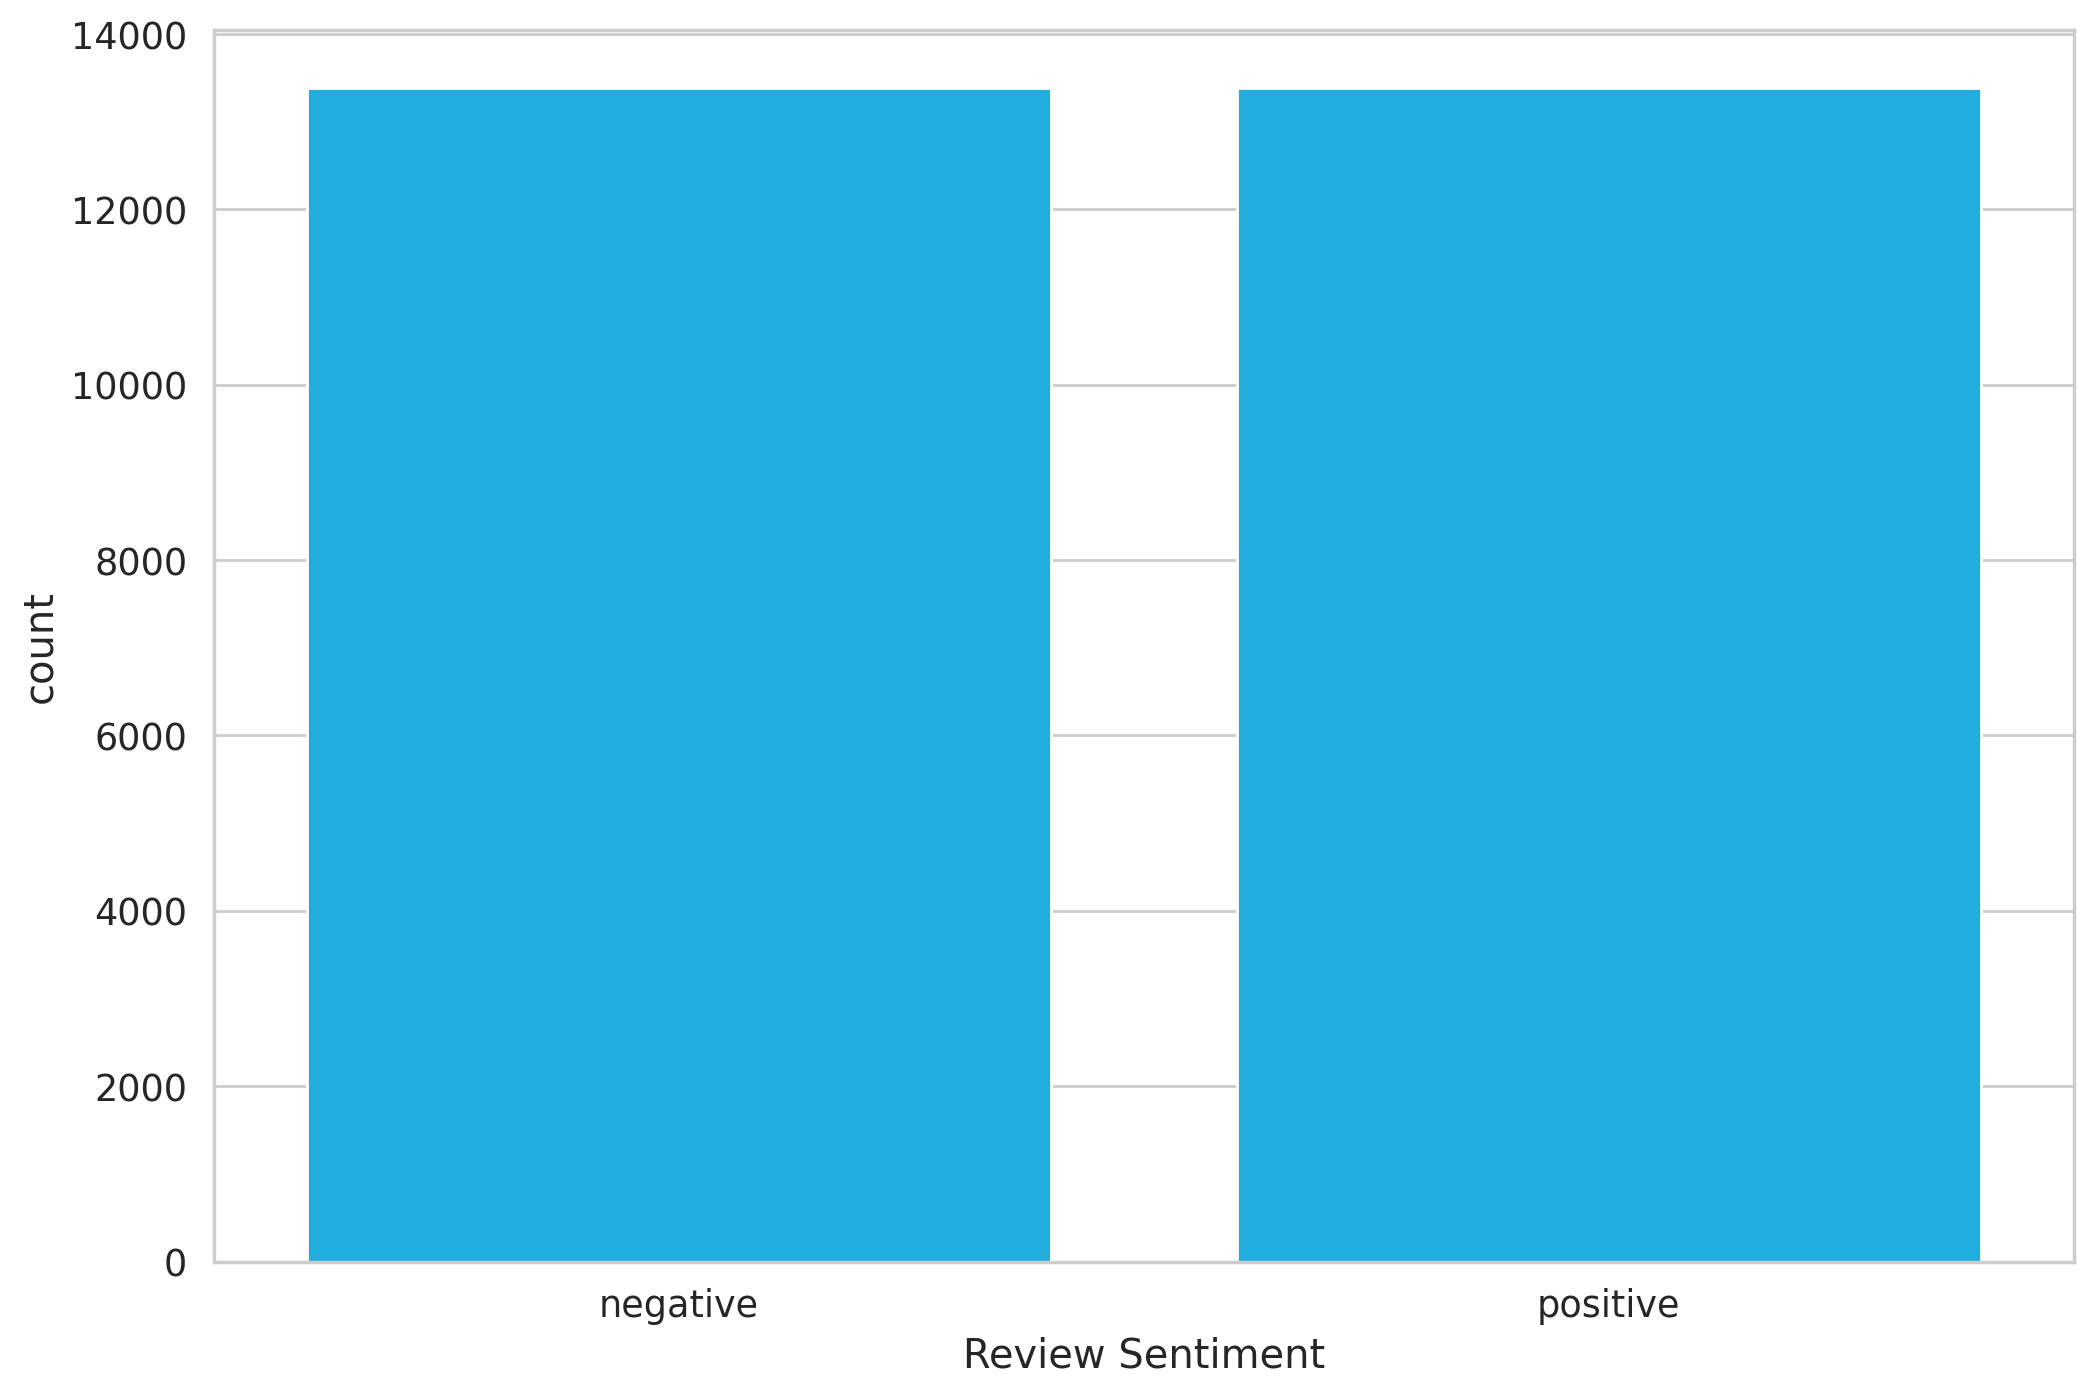

In [ ]:
# Looking for balance
ax = sns.countplot(data=df, x='sentiment')
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names)

In [ ]:
df.value_counts('sentiment')

,count
sentiment,
0,13382
1,13382


## Data PreProcessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)

In [ ]:
print(tokens) # Everything in lowercase and punctuation is kept intact

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


### Special Tokens

- Sequence classification

Important tokens

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# If a word/token is not recognised by tokenizer
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
# Encode the sample text using DistilBERT's tokenizer

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
    padding = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'          # Return the output as PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

17


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

17


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

We can inverse the tokenization to have a look at the special tokens

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]']

### Choosing sequence length

- look at distribution in dataset and set a threshold

In [ ]:
# Create an empty list to store the length of tokens
token_len = []

for txt in df.content: # Iterate over each text in the 'content' column

    # Encode the text using DistilBERT's tokenizer, with a length of 400
    tokens = tokenizer.encode(txt, max_length=400, truncation=True)

    # Append the length of the tokenized output to the list
    token_len.append(len(tokens))

Text(0.5, 0, 'Token count')

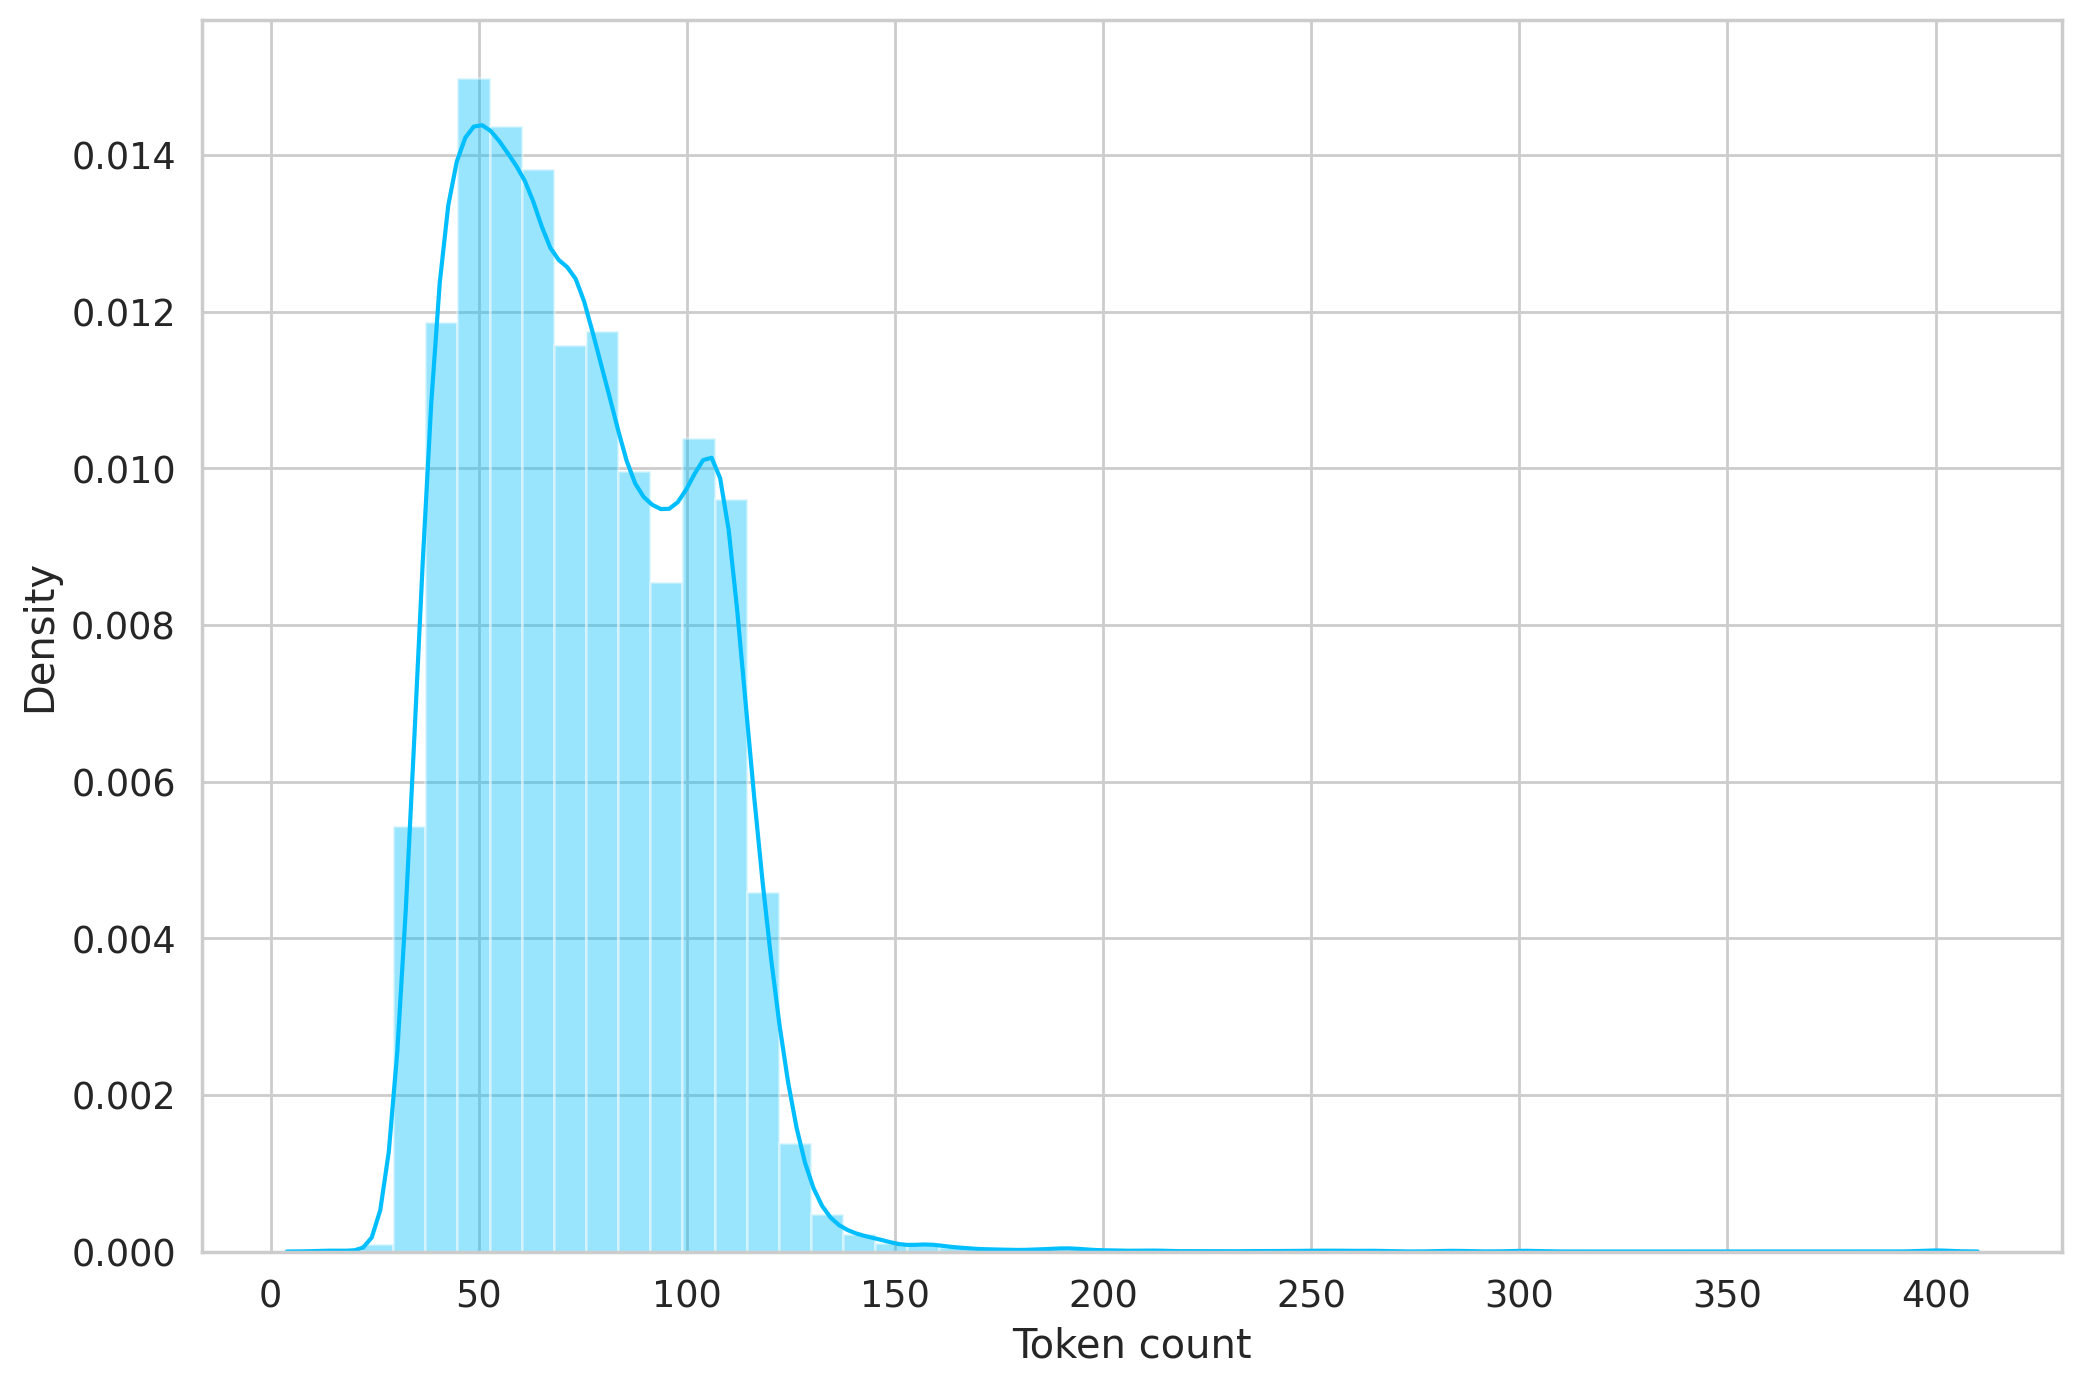

In [ ]:
sns.distplot(token_len)
plt.xlabel('Token count')

Most of the reviews seem to contain less than 160 tokens, but we'll be on the safe side and choose a maximum length of 200.

## Create a dataset

In [ ]:
MAX_LEN = 300

In [ ]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        add_special_tokens = True,
        padding = 'max_length',
        truncation=True,
        return_attention_mask = True,
        return_token_type_ids = False,
        return_tensors = 'pt'
        )

        return {
            'review_text': review,
            'input_ids' : encoding['input_ids'].squeeze(0),
            'attention_mask' : encoding['attention_mask'].squeeze(0),
            'targets' : torch.tensor(self.targets[item], dtype=torch.long)
        }

## Splitting into training and test sets

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((21411, 14), (2676, 14), (2677, 14))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 4
    )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 300])
torch.Size([16, 300])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, dropout_rate=0.1):
        super(SentimentClassifier, self).__init__()
        self.bert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)


    def forward(self, input_ids, attention_mask):
        # Get the logits directly from DistilBertForSequenceClassification
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token representation
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
                # Return the entire output object containing logits
        return logits


In [ ]:
model = SentimentClassifier(n_classes=len(class_names),dropout_rate=0.1)

In [ ]:
output = model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

print(output.size())

torch.Size([1, 2])


In [ ]:
model

SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [ ]:
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 300])
torch.Size([16, 300])


In [ ]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
print(F.softmax(outputs, dim=1))

tensor([[0.4890, 0.5110],
        [0.5108, 0.4892],
        [0.5929, 0.4071],
        [0.4705, 0.5295],
        [0.5708, 0.4292],
        [0.4881, 0.5119],
        [0.4908, 0.5092],
        [0.5568, 0.4432],
        [0.5284, 0.4716],
        [0.5419, 0.4581],
        [0.5095, 0.4905],
        [0.5951, 0.4049],
        [0.4935, 0.5065],
        [0.5852, 0.4148],
        [0.5483, 0.4517],
        [0.5551, 0.4449]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## Training

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS

num_warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        # Forward pass
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        # Get the logits from the output and calculate predictions
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        # Accumulate correct predictions
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get the logits from the output and calculate predictions
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            # Accumulate correct predictions
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model,train_data_loader, loss_fn,
                                        optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model,val_data_loader,loss_fn, device, len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.44746901720339366 accuracy 0.7945915650833684
Val   loss 0.2998926603856186 accuracy 0.8770553064275037

Epoch 2/10
----------
Train loss 0.2887105847889025 accuracy 0.8851524917098688
Val   loss 0.2886751756692926 accuracy 0.8875186846038864

Epoch 3/10
----------
Train loss 0.2616395223176328 accuracy 0.900518425108589
Val   loss 0.2929964511145261 accuracy 0.8856502242152466

Epoch 4/10
----------
Train loss 0.24100257571622496 accuracy 0.9107935173508944
Val   loss 0.3079570104046503 accuracy 0.8920029895366218

Epoch 5/10
----------
Train loss 0.2249454370928654 accuracy 0.9213021344168886
Val   loss 0.3316538130997547 accuracy 0.8901345291479821

Epoch 6/10
----------
Train loss 0.2106170015391505 accuracy 0.9286815188454534
Val   loss 0.34841228489364895 accuracy 0.8871449925261585

Epoch 7/10
----------
Train loss 0.198897471246633 accuracy 0.9338657699313437
Val   loss 0.37508868029440884 accuracy 0.8845291479820628

Epoch 8/10
----------
Tra

In [ ]:
model = SentimentClassifier(len(class_names))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Sentiment Analysis with BERT/notebooks/best_model_state.bin'))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
model.eval()

SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

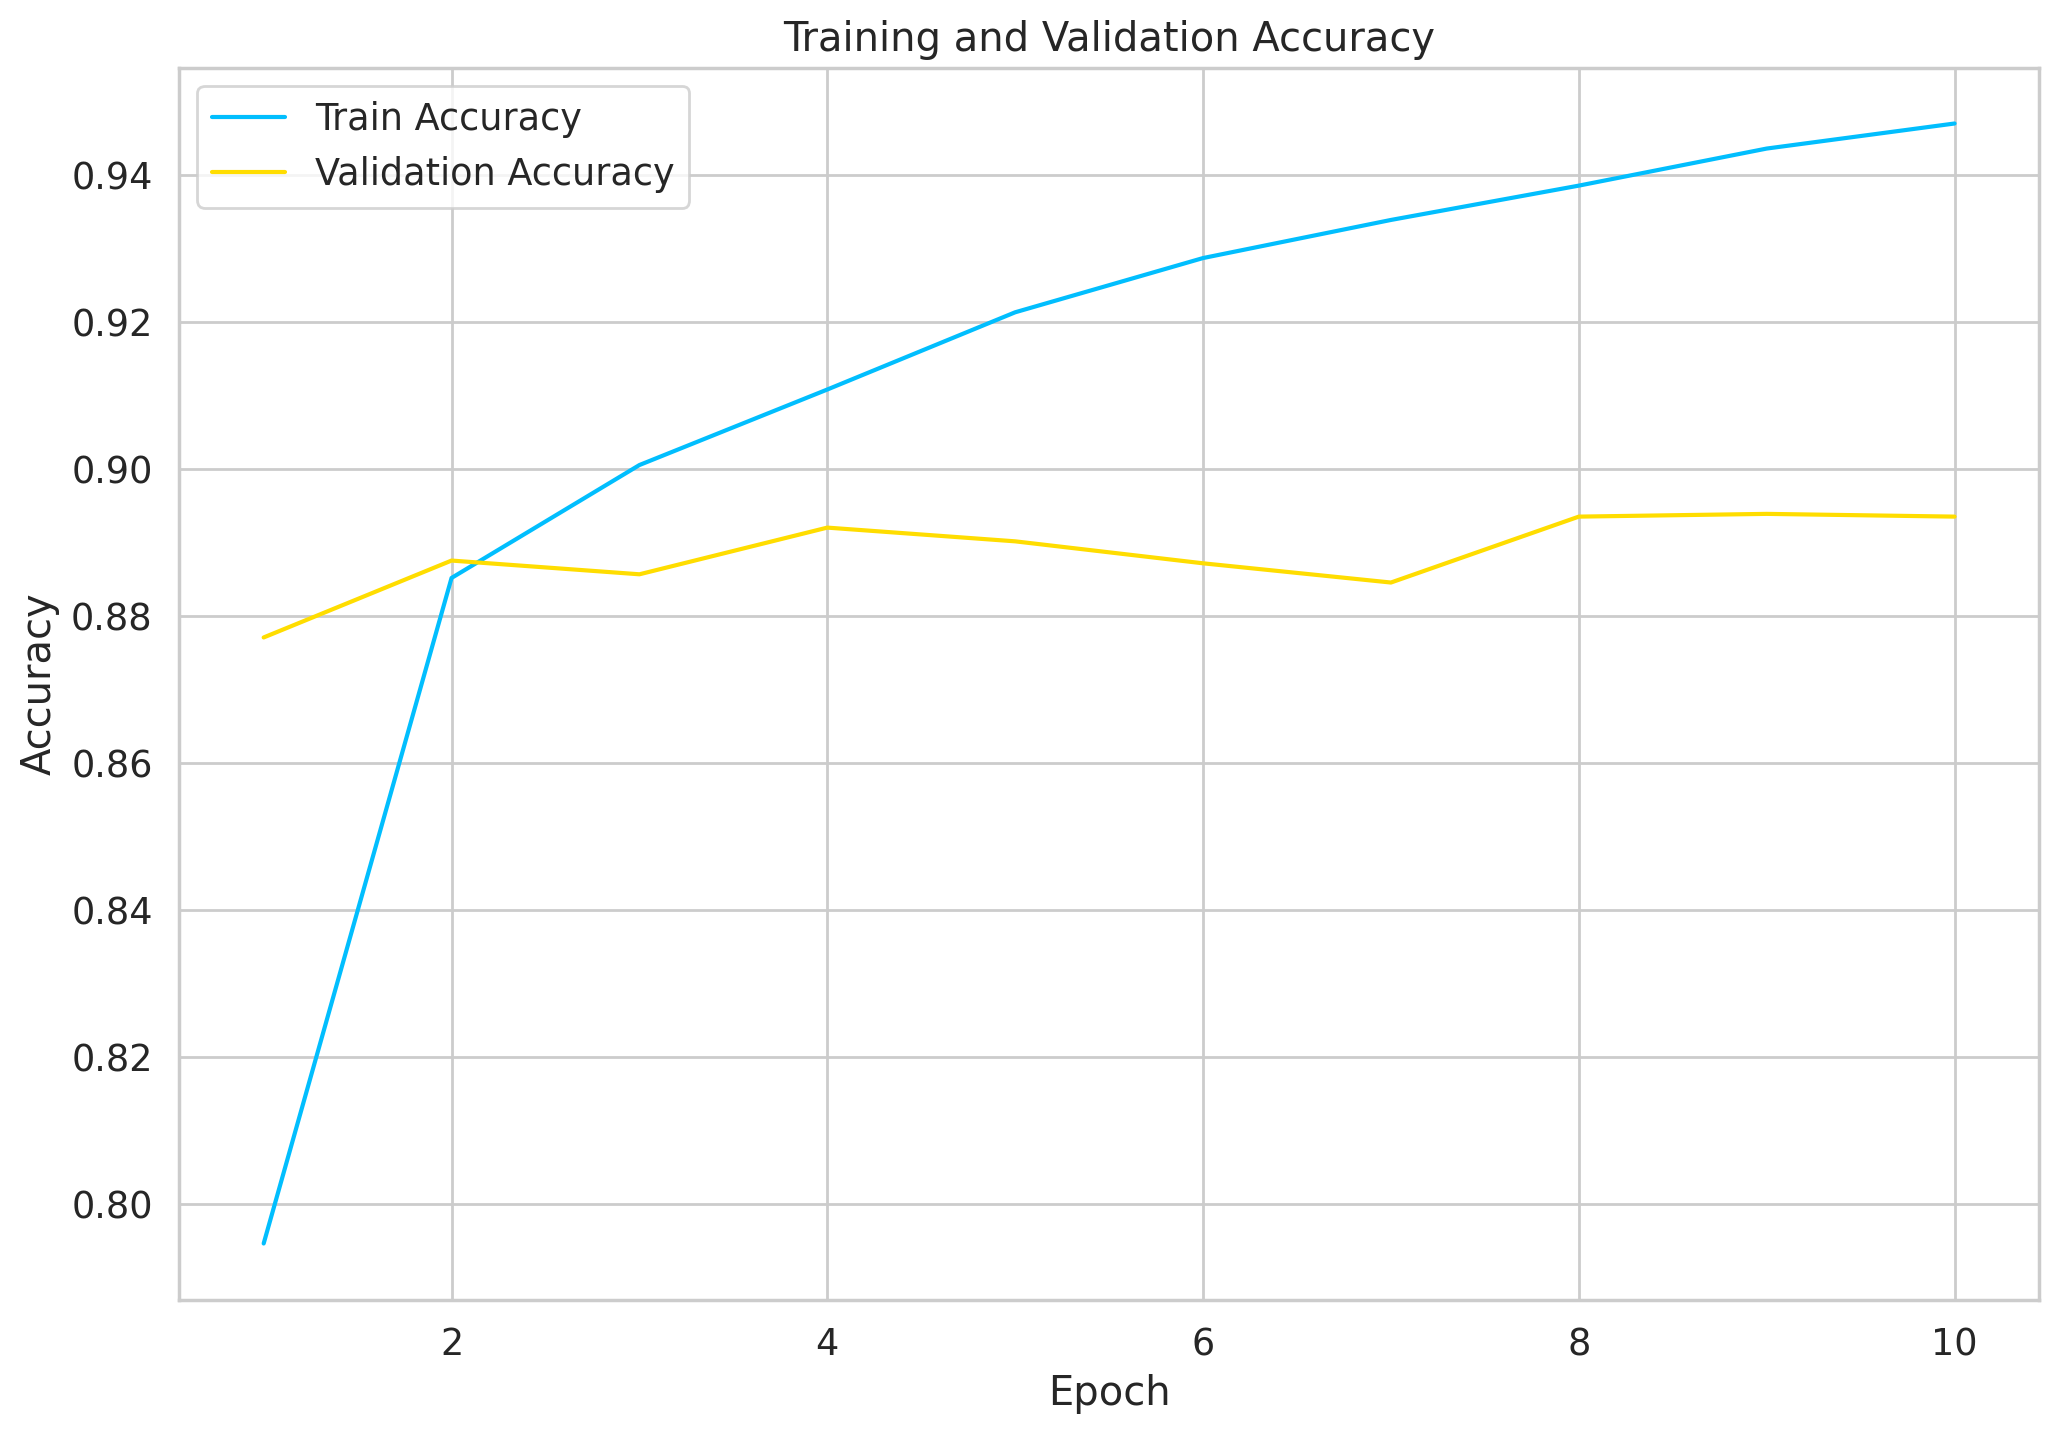

In [ ]:
# The training and validation accuracies
train_acc = [0.7945915650833684, 0.8851524917098688, 0.900518425108589, 0.9107935173508944, 0.9213021344168886,
             0.9286815188454534, 0.9338657699313437, 0.9385362664051189, 0.9435804025967961, 0.9469898650226519]
val_acc = [0.8770553064275037, 0.8875186846038864, 0.8856502242152466, 0.8920029895366218, 0.8901345291479821,
           0.8871449925261585, 0.8845291479820628, 0.8934977578475337, 0.8938714499252616, 0.8934977578475337]

# Plotting the accuracy
plt.plot(range(1, 11), train_acc, label='Train Accuracy')
plt.plot(range(1, 11), val_acc, label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Evaluation

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

In [ ]:
test_acc, _ = eval_model(model,test_data_loader,loss_fn,device,len(df_test))

In [ ]:
test_acc.item()

0.8946581994770265

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.91      0.90      1324
    positive       0.91      0.88      0.89      1353

    accuracy                           0.89      2677
   macro avg       0.90      0.89      0.89      2677
weighted avg       0.90      0.89      0.89      2677



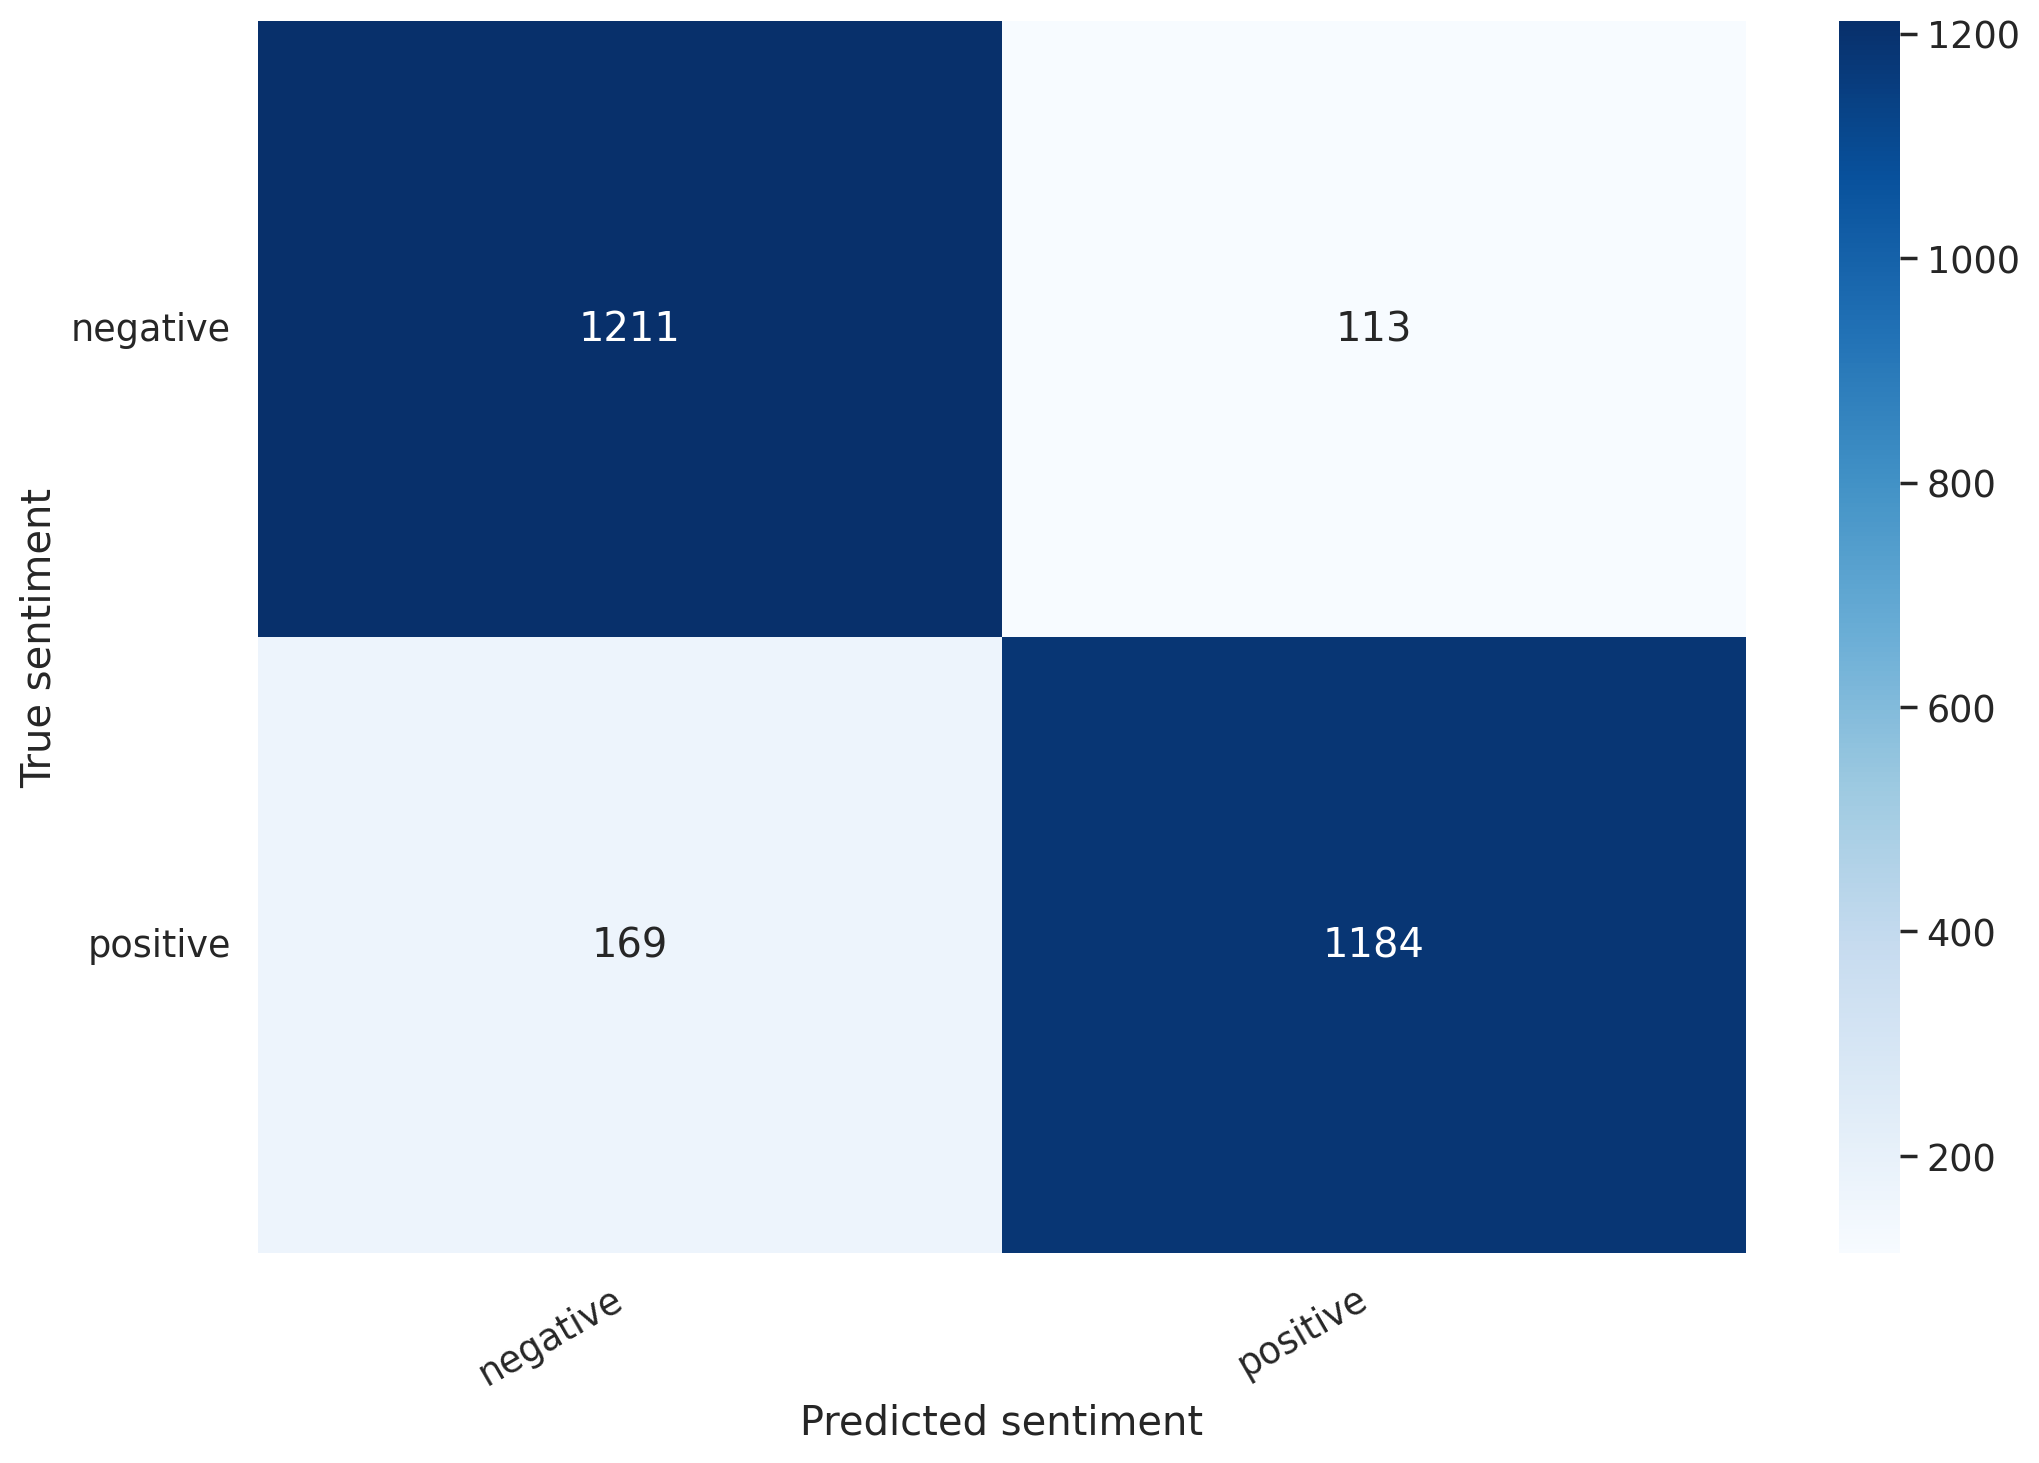

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 3
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

we are waiting for 30 minutes but they do not serve me while the
online order is delivered in front of me. we are asking 3-4 times to
serve the order they are not serving my order. I have a worse
experience at Domino's at bhikaji cama place.

True sentiment: negative


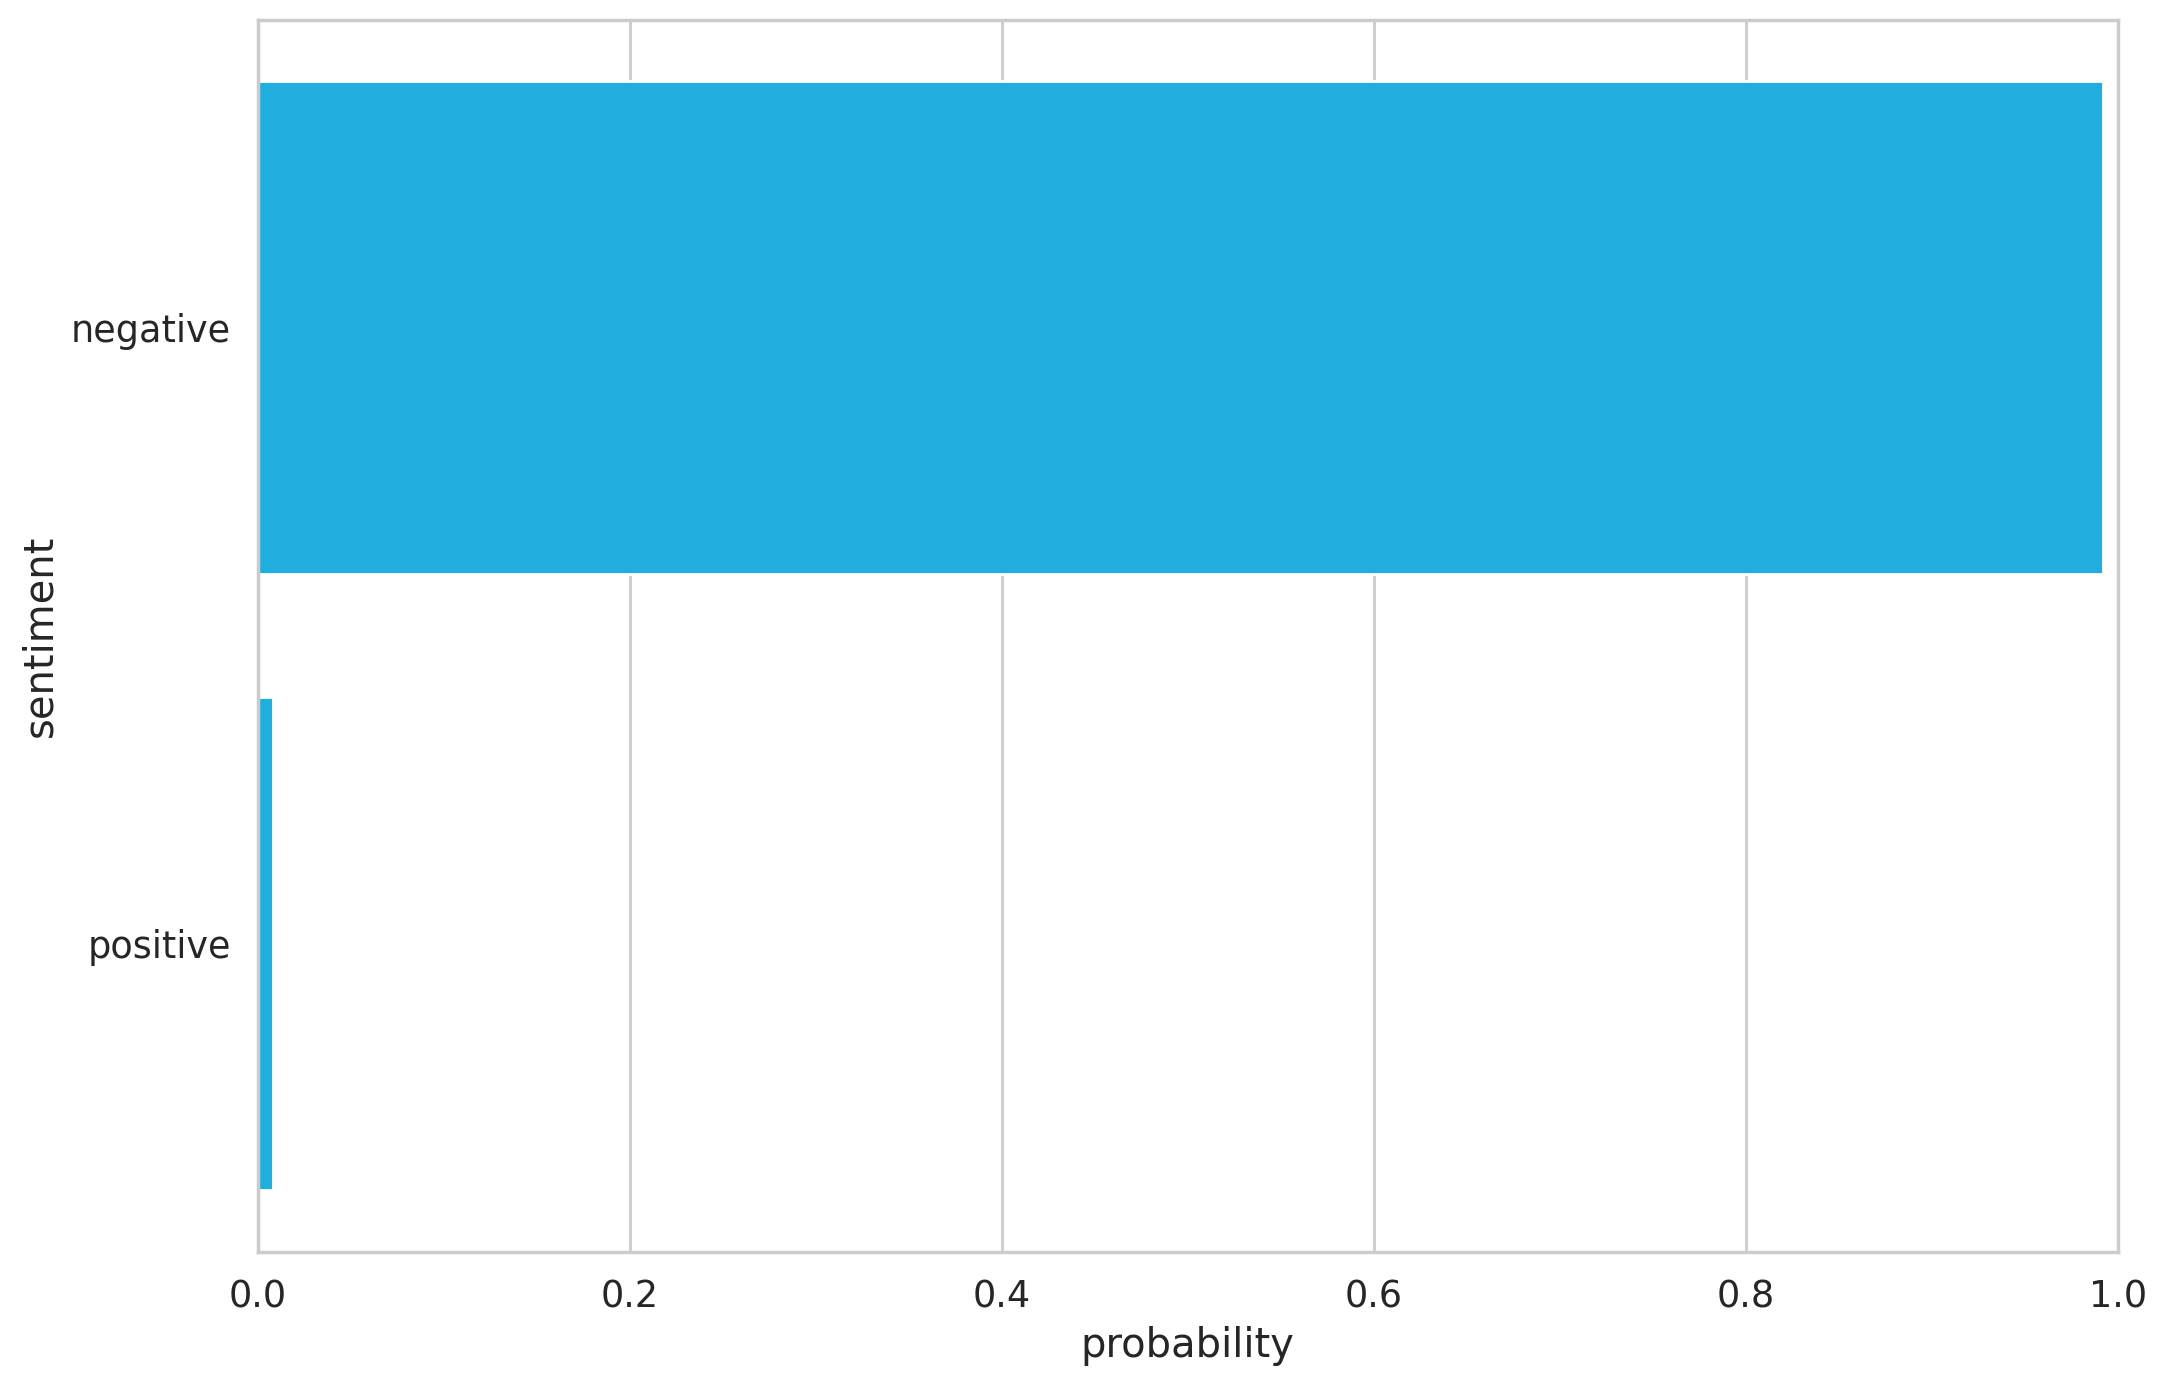

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
# Predicting on raw text

In [ ]:
review_text = "Swiggy makes ordering food so easy with a wide variety of options available at your fingertips. The delivery is fast, and the app interface is seamless, ensuring a smooth and convenient experience every time."

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Swiggy makes ordering food so easy with a wide variety of options available at your fingertips. The delivery is fast, and the app interface is seamless, ensuring a smooth and convenient experience every time.
Sentiment  : positive
